# [Intriguing properties of neural networks](http://arxiv.org/abs/1312.6199)

​This paper reports two counter-intuitive properties:

- It is the **space**, rather than the individual units, that contains the semantic information in the high layers of neural networks.
- We can cause the network to **misclassify an image** by applying **a certain hardly perceptible perturbation**, which is found by maximizing the network’s prediction error. In addition, the specific nature of these perturbations is not a random artifact of learning: the same perturbation can cause a different network, that was trained on a different subset of the dataset, to misclassify the same input.

​We term the so perturbed examples “**adversarial examples**”. These results suggest that the deep neural networks that are learned by backpropagation have nonintuitive characteristics and intrinsic blind spots, **whose structure is connected to the data distribution in a non-obvious way**.

## Framework

For the MNIST dataset, we used a simple fully connected network with one or more hidden layers and a Softmax classifier. We refer to this network as “FC”.

In [64]:
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data

import torchvision
import torchvision.utils as vutils
import torchvision.transforms as transforms
import torchvision.datasets as dset

import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
mnist_train = dset.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=100, shuffle=True)
mnist_test = dset.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=10000, shuffle=False)

In [66]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In order to test the cross-model generalization of adversarial examples, we define FC100_100_10 and FC10 as belows.

In [67]:
class FC100_100_10(nn.Module):
    def __init__(self):
        super(FC100_100_10, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU()
        )
        
        self.layer_2 = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU()
        )
        
        self.layer_3 = nn.Sequential(
            nn.Linear(100, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        out_1 = self.layer_1(x)
        out_2 = self.layer_2(out_1)
        out_3 = self.layer_3(out_2)
    
        return out_3, out_2, out_1
    
class FC10(nn.Module):
    def __init__(self):
        super(FC10, self).__init__()

        self.layer_1 = nn.Sequential(
            nn.Linear(28*28, 10)
        )
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        out_1 = self.layer_1(x)
    
        return out_1

model_1=FC100_100_10().to(device)
model_2=FC10().to(device)

In [68]:
loss = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam([{'params': model_1.layer_1.parameters(), 'weight_decay': (1e-5)/100}, 
                                {'params': model_1.layer_2.parameters(), 'weight_decay': (1e-5)/100},
                                {'params': model_1.layer_3.parameters(), 'weight_decay': (1e-6)/10}], lr=0.001)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=0.0001, weight_decay=1)


In [69]:
for epoch in range(10):
    for i, (images, labels) in enumerate(train_iter):
        X=images.to(device)
        Y=labels.to(device)

        pre,_,_=model_1(X)
        cost=loss(pre,Y)

        optimizer_1.zero_grad()
        cost.backward()
        optimizer_1.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('FC100_100_10 finished Training on the 60000 training images')

epoch:[1/10], iter:[100/600], loss:0.42694
epoch:[1/10], iter:[200/600], loss:0.30483
epoch:[1/10], iter:[300/600], loss:0.23454
epoch:[1/10], iter:[400/600], loss:0.22123
epoch:[1/10], iter:[500/600], loss:0.39596
epoch:[1/10], iter:[600/600], loss:0.18158
epoch:[2/10], iter:[100/600], loss:0.26654
epoch:[2/10], iter:[200/600], loss:0.07321
epoch:[2/10], iter:[300/600], loss:0.12536
epoch:[2/10], iter:[400/600], loss:0.16849
epoch:[2/10], iter:[500/600], loss:0.18552
epoch:[2/10], iter:[600/600], loss:0.18772
epoch:[3/10], iter:[100/600], loss:0.07913
epoch:[3/10], iter:[200/600], loss:0.06078
epoch:[3/10], iter:[300/600], loss:0.15018
epoch:[3/10], iter:[400/600], loss:0.03555
epoch:[3/10], iter:[500/600], loss:0.08080
epoch:[3/10], iter:[600/600], loss:0.13348
epoch:[4/10], iter:[100/600], loss:0.11100
epoch:[4/10], iter:[200/600], loss:0.10838
epoch:[4/10], iter:[300/600], loss:0.13852
epoch:[4/10], iter:[400/600], loss:0.09427
epoch:[4/10], iter:[500/600], loss:0.04051
epoch:[4/10

In [70]:
for epoch in range(10):
    for i, (images, labels) in enumerate(train_iter):
        X=images.to(device)
        Y=labels.to(device)

        pre=model_2(X)
        cost=loss(pre,Y)

        optimizer_2.zero_grad()
        cost.backward()
        optimizer_2.step()

        if (i+1)%100==0:
            print('epoch:[%d/%d], iter:[%d/%d], loss:%.5f' % (epoch+1,10,i+1,len(train_iter),cost.item()))
print('FC10 finished Training on the 60000 training images')

epoch:[1/10], iter:[100/600], loss:2.12590
epoch:[1/10], iter:[200/600], loss:1.98526
epoch:[1/10], iter:[300/600], loss:1.88840
epoch:[1/10], iter:[400/600], loss:1.74579
epoch:[1/10], iter:[500/600], loss:1.75395
epoch:[1/10], iter:[600/600], loss:1.66630
epoch:[2/10], iter:[100/600], loss:1.66415
epoch:[2/10], iter:[200/600], loss:1.61407
epoch:[2/10], iter:[300/600], loss:1.65554
epoch:[2/10], iter:[400/600], loss:1.61530
epoch:[2/10], iter:[500/600], loss:1.66911
epoch:[2/10], iter:[600/600], loss:1.62000
epoch:[3/10], iter:[100/600], loss:1.63472
epoch:[3/10], iter:[200/600], loss:1.70436
epoch:[3/10], iter:[300/600], loss:1.63700
epoch:[3/10], iter:[400/600], loss:1.58486
epoch:[3/10], iter:[500/600], loss:1.53536
epoch:[3/10], iter:[600/600], loss:1.60108
epoch:[4/10], iter:[100/600], loss:1.66034
epoch:[4/10], iter:[200/600], loss:1.67871
epoch:[4/10], iter:[300/600], loss:1.61678
epoch:[4/10], iter:[400/600], loss:1.64841
epoch:[4/10], iter:[500/600], loss:1.55977
epoch:[4/10

In [71]:
model_1.eval()

total = 0
correct = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    outputs,_,_ = model_1(images)
    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
    _,predicted = torch.max(outputs.data, dim=1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of FC100_100_10 on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of FC100_100_10 on the 10000 test images: 97.489998 %


In [72]:
model_2.eval()

total = 0
correct = 0

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    
    outputs = model_2(images)
    # torch.max(outputs.data, 1)输出每一行的最大值(value, index)
    _,predicted = torch.max(outputs.data, dim=1)

    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of FC10 on the 10000 test images: %f %%' % (100 * correct / total))

Accuracy of FC10 on the 10000 test images: 78.809998 %


## Units of $φ(x)$

Visual inspection of images $x′$, which satisfy (or are close to maximum attainable value):

$$
x′ = \arg \underset{x \in \mathcal{I}} {max} <φ(x),v>
$$


In [73]:
def imshow(img):
    image = img.cpu().clone().numpy()
    plt.figure(figsize=(10, 20))
    # image -> (channel, row, col)
    # plt.imshow(row,col,channel)
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.show()

### in the natural basis direction

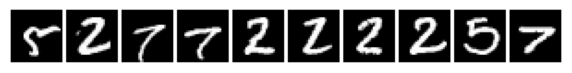

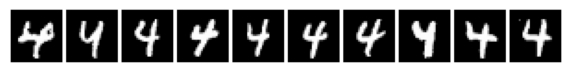

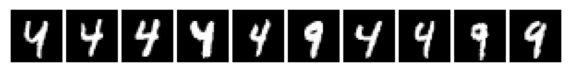

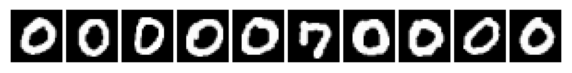

In [74]:
for i in range(4):
    unit = torch.eye(100)[i,:]

    for images, labels in test_loader:
        images = images.to(device)
        
        _,phi_x,_ = model_1(images)
        values=torch.mv(phi_x.cpu(),unit)
    
    top_index = np.argsort(values.data.numpy())[-10:]
    top_image= images[top_index]
        
    imshow(torchvision.utils.make_grid(top_image, normalize=True, pad_value=1, nrow=10))

### in a random basis

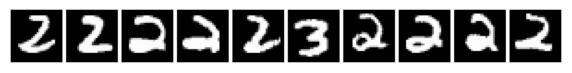

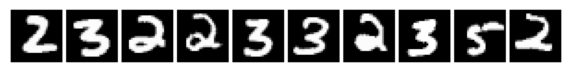

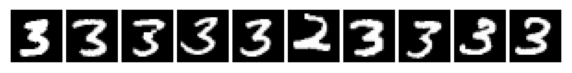

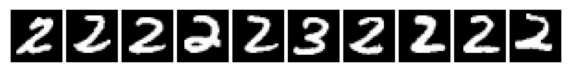

In [75]:
for i in range(4):
    direction= torch.rand(100)
    
    for images, labels in test_loader:
        images = images.to(device)
        
        _,phi_x,_ = model_1(images)
        values=torch.mv(phi_x.cpu(),direction)
    
    top_index = np.argsort(values.data.numpy())[-10:]
    top_image= images[top_index]
        
    imshow(torchvision.utils.make_grid(top_image, normalize=True, pad_value=1, nrow=10))

The experiment suggests that the natural basis is not better than a random basis for inspecting the properties of $φ(x)$. This puts into question the notion that neural networks disentangle variation factors across coordinates.

## Blind Spots in Neural Networks(“**adversarial examples**”)

For a small enough radius $ε > 0$ in the vicinity of a given training input $x$, an $x + r$ satisfying $||r|| < ε$ will get assigned a high probability of the correct class by the model. This kind of **smoothness prior** is typically valid for computer vision problems. In general, imperceptibly tiny perturbations of a given image do not normally change the underlying class.

Our main result is that for deep neural networks, the smoothness assumption that underlies many kernel methods does not hold. Specifically, we show that by using a simple optimization procedure, we are able to find adversarial examples, which are obtained by imperceptibly small perturbations to a correctly classified input image, so that it is no longer classified correctly.


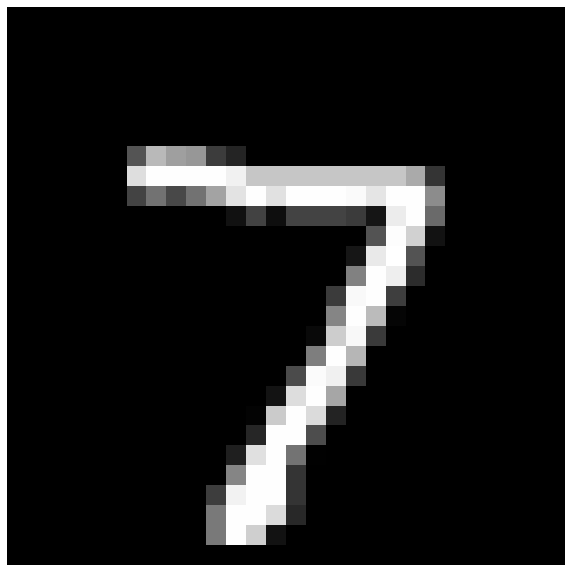

In [76]:
sample_img=mnist_test[0][0].cuda()
output,_,_=model_1(sample_img.to(device))
_,prediction=torch.max(output.data,1)
imshow(torchvision.utils.make_grid(sample_img, normalize=True))

In [77]:
def distortion(a,b):
    return torch.sqrt(torch.sum((a-b)**2)/784)

We aim to solve the following box-constrained optimization problem:

$$
\min ||r||_{2} \\s.t. \quad f(x+r)=l \\ \qquad \qquad x+r \in [0,1]^{m}
$$

or:

$$
\min c||r||_{2}+loss_{f}(x+r,l) \quad s.t. \quad x+r \in [0,1]^{m}
$$

num: 0, epoch: [100/1000], prediction: 0, loss_adv: 29.69211
num: 0, epoch: [200/1000], prediction: 0, loss_adv: 14.32861
num: 0, epoch: [300/1000], prediction: 0, loss_adv: 0.38881
num: 0, epoch: [400/1000], prediction: 0, loss_adv: 0.00515
num: 0, epoch: [500/1000], prediction: 0, loss_adv: 0.00766
num: 0, epoch: [600/1000], prediction: 0, loss_adv: 0.02254
num: 0, epoch: [700/1000], prediction: 0, loss_adv: 0.01925
num: 0, epoch: [800/1000], prediction: 0, loss_adv: 0.01855
num: 0, epoch: [900/1000], prediction: 0, loss_adv: 0.02073
Attack success! The number is 0 and the distortion is 0.091932


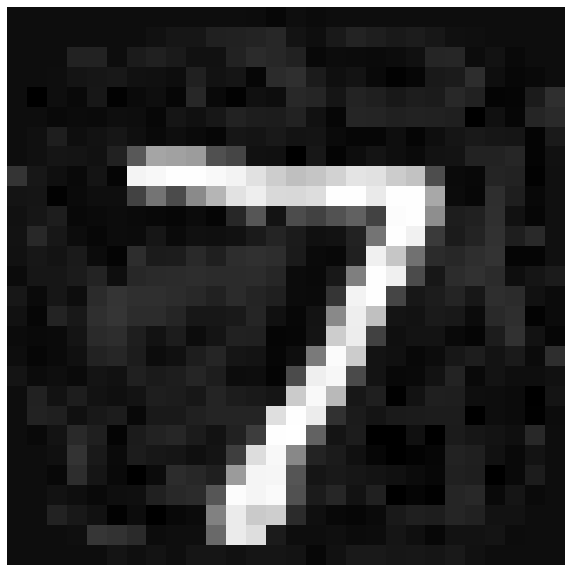

num: 1, epoch: [100/1000], prediction: 1, loss_adv: 167.37244
num: 1, epoch: [200/1000], prediction: 1, loss_adv: 150.42197
num: 1, epoch: [300/1000], prediction: 1, loss_adv: 136.40289
num: 1, epoch: [400/1000], prediction: 1, loss_adv: 122.48158
num: 1, epoch: [500/1000], prediction: 1, loss_adv: 108.50898
num: 1, epoch: [600/1000], prediction: 1, loss_adv: 94.47890
num: 1, epoch: [700/1000], prediction: 1, loss_adv: 80.39082
num: 1, epoch: [800/1000], prediction: 1, loss_adv: 66.27824
num: 1, epoch: [900/1000], prediction: 1, loss_adv: 52.13442
Attack success! The number is 1 and the distortion is 0.077844


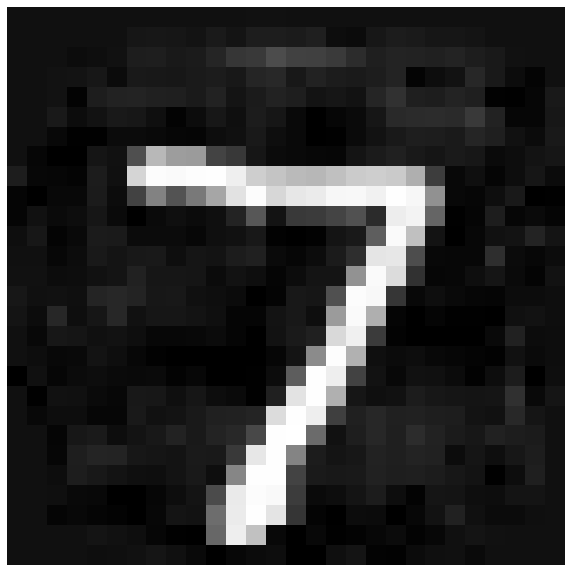

num: 2, epoch: [100/1000], prediction: 2, loss_adv: 39.19783
num: 2, epoch: [200/1000], prediction: 2, loss_adv: 24.04923
num: 2, epoch: [300/1000], prediction: 2, loss_adv: 10.44053
num: 2, epoch: [400/1000], prediction: 2, loss_adv: 0.03955
num: 2, epoch: [500/1000], prediction: 2, loss_adv: 0.01269
num: 2, epoch: [600/1000], prediction: 2, loss_adv: 0.01401
num: 2, epoch: [700/1000], prediction: 2, loss_adv: 0.00748
num: 2, epoch: [800/1000], prediction: 2, loss_adv: 0.00175
num: 2, epoch: [900/1000], prediction: 2, loss_adv: 0.00654
Attack success! The number is 2 and the distortion is 0.107691


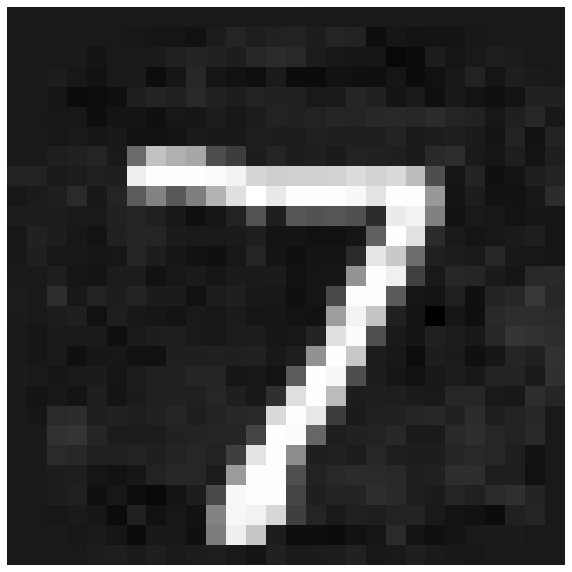

num: 3, epoch: [100/1000], prediction: 3, loss_adv: 27.34269
num: 3, epoch: [200/1000], prediction: 3, loss_adv: 12.43581
num: 3, epoch: [300/1000], prediction: 3, loss_adv: 0.33939
num: 3, epoch: [400/1000], prediction: 3, loss_adv: 0.02292
num: 3, epoch: [500/1000], prediction: 3, loss_adv: 0.01002
num: 3, epoch: [600/1000], prediction: 3, loss_adv: 0.01935
num: 3, epoch: [700/1000], prediction: 3, loss_adv: 0.02235
num: 3, epoch: [800/1000], prediction: 3, loss_adv: 0.00975
num: 3, epoch: [900/1000], prediction: 3, loss_adv: 0.01911
Attack success! The number is 3 and the distortion is 0.127759


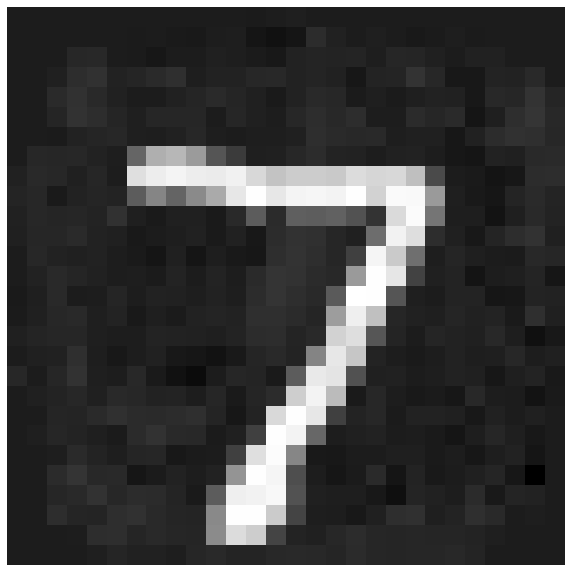

num: 4, epoch: [100/1000], prediction: 7, loss_adv: 2135.37476
num: 4, epoch: [200/1000], prediction: 7, loss_adv: 2101.30884
num: 4, epoch: [300/1000], prediction: 7, loss_adv: 2086.35059
num: 4, epoch: [400/1000], prediction: 7, loss_adv: 2072.41333
num: 4, epoch: [500/1000], prediction: 7, loss_adv: 2058.51685
num: 4, epoch: [600/1000], prediction: 7, loss_adv: 2044.60315
num: 4, epoch: [700/1000], prediction: 7, loss_adv: 2030.66516
num: 4, epoch: [800/1000], prediction: 7, loss_adv: 2016.71082
num: 4, epoch: [900/1000], prediction: 7, loss_adv: 2002.73499
num: 5, epoch: [100/1000], prediction: 5, loss_adv: 704.95148
num: 5, epoch: [200/1000], prediction: 5, loss_adv: 683.17542
num: 5, epoch: [300/1000], prediction: 5, loss_adv: 668.96149
num: 5, epoch: [400/1000], prediction: 5, loss_adv: 655.09644
num: 5, epoch: [500/1000], prediction: 5, loss_adv: 641.23773
num: 5, epoch: [600/1000], prediction: 5, loss_adv: 627.35858
num: 5, epoch: [700/1000], prediction: 5, loss_adv: 613.45227

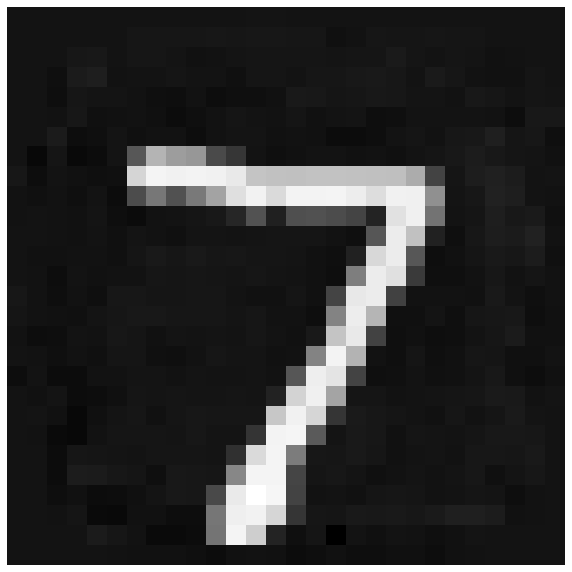

num: 6, epoch: [100/1000], prediction: 6, loss_adv: 114.37978
num: 6, epoch: [200/1000], prediction: 6, loss_adv: 96.60589
num: 6, epoch: [300/1000], prediction: 6, loss_adv: 82.35428
num: 6, epoch: [400/1000], prediction: 6, loss_adv: 68.41564
num: 6, epoch: [500/1000], prediction: 6, loss_adv: 54.44660
num: 6, epoch: [600/1000], prediction: 6, loss_adv: 40.42268
num: 6, epoch: [700/1000], prediction: 6, loss_adv: 26.34959
num: 6, epoch: [800/1000], prediction: 6, loss_adv: 12.22064
num: 6, epoch: [900/1000], prediction: 6, loss_adv: 0.01481
Attack success! The number is 6 and the distortion is 0.082068


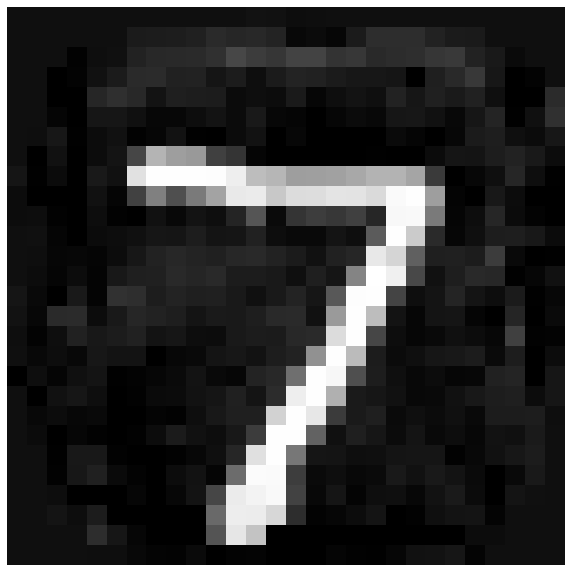

num: 7, epoch: [100/1000], prediction: 7, loss_adv: 25.93856
num: 7, epoch: [200/1000], prediction: 7, loss_adv: 12.22631
num: 7, epoch: [300/1000], prediction: 7, loss_adv: 0.29090
num: 7, epoch: [400/1000], prediction: 7, loss_adv: 0.00407
num: 7, epoch: [500/1000], prediction: 7, loss_adv: 0.00418
num: 7, epoch: [600/1000], prediction: 7, loss_adv: 0.00418
num: 7, epoch: [700/1000], prediction: 7, loss_adv: 0.00418
num: 7, epoch: [800/1000], prediction: 7, loss_adv: 0.00419
num: 7, epoch: [900/1000], prediction: 7, loss_adv: 0.00419
num: 8, epoch: [100/1000], prediction: 8, loss_adv: 31.08105
num: 8, epoch: [200/1000], prediction: 8, loss_adv: 15.41127
num: 8, epoch: [300/1000], prediction: 8, loss_adv: 1.25267
num: 8, epoch: [400/1000], prediction: 8, loss_adv: 0.01889
num: 8, epoch: [500/1000], prediction: 8, loss_adv: 0.01673
num: 8, epoch: [600/1000], prediction: 8, loss_adv: 0.01597
num: 8, epoch: [700/1000], prediction: 8, loss_adv: 0.01556
num: 8, epoch: [800/1000], predictio

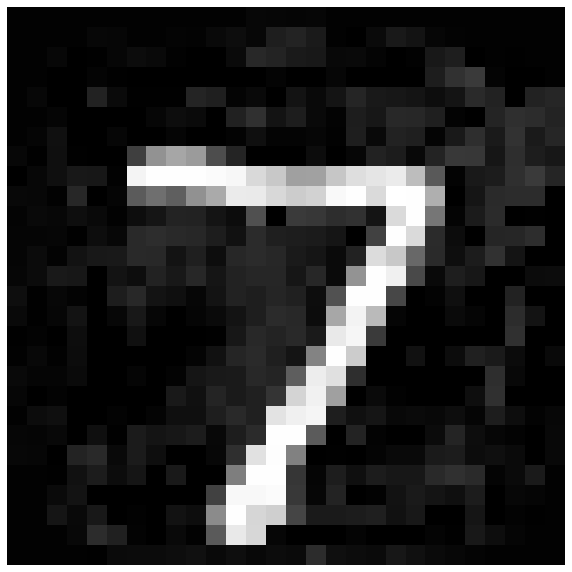

num: 9, epoch: [100/1000], prediction: 9, loss_adv: 38.26445
num: 9, epoch: [200/1000], prediction: 9, loss_adv: 22.86666
num: 9, epoch: [300/1000], prediction: 9, loss_adv: 9.00396
num: 9, epoch: [400/1000], prediction: 9, loss_adv: 0.06553
num: 9, epoch: [500/1000], prediction: 9, loss_adv: 0.04275
num: 9, epoch: [600/1000], prediction: 9, loss_adv: 0.02020
num: 9, epoch: [700/1000], prediction: 9, loss_adv: 0.00597
num: 9, epoch: [800/1000], prediction: 9, loss_adv: 0.02307
num: 9, epoch: [900/1000], prediction: 9, loss_adv: 0.01221
Attack success! The number is 9 and the distortion is 0.061542


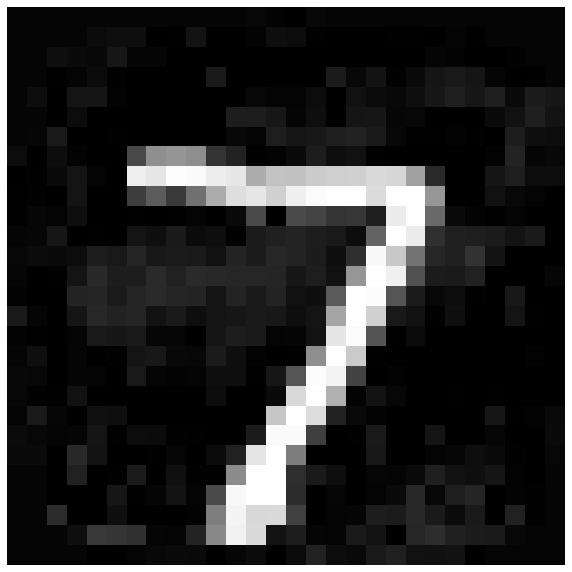

In [79]:
right=sample_img-torch.zeros_like(sample_img).cuda()
left=sample_img-torch.ones_like(sample_img).cuda()

m=100
for num in range(10):

    r = torch.zeros_like(sample_img).cuda()
    r.requires_grad = True
    
    c = torch.rand(1).cuda()
    c = 1 / (c + 1e-10)
    c.requires_grad = True

    #optimizer_adv = torch.optim.LBFGS([r, c], lr=0.01 , line_search_fn='strong_wolfe', history_size=m)
    optimizer_adv = torch.optim.Adam([r, c], lr=0.005)
    
    for i in range(1000):

        X = sample_img.cuda() + r.cuda()
        X = (X - torch.min(X)) / (torch.max(X) - torch.min(X))
        Y = torch.tensor([num]).cuda()

        output,_,_ = model_1(X)
        _,prediction = torch.max(output.data,1)

        cost = torch.norm(r-left, p=2).cuda() + torch.norm(right-r, p=2).cuda()
        loss_adv= c.abs() * cost + loss(output,Y)

        def closure():
            return loss_adv
        
        optimizer_adv.zero_grad()
        loss_adv.backward(retain_graph=True)
        optimizer_adv.step(closure=closure)

        if (i+1) == 1000:

            if prediction.item() != 7 and prediction.item() == num:

                print('Attack success! The number is %d and the distortion is %f' % (prediction.item(), distortion(X, sample_img).item()))
                imshow(torchvision.utils.make_grid(X.data.cpu(), normalize=True))

        elif (i+1) % 100 == 0:
            print('num: %d, epoch: [%d/%d], prediction: %d, loss_adv: %.5f' % (num, i+1, 1000, prediction.item(), loss_adv.item()))


Adversarial examples have the following intriguing properties:
1. For each sample, we have always managed to generate very close, visually hard to distinguish, adversarial examples that are misclassified by the original network. 
2. Cross model generalization: a relatively large fraction of examples will be misclassified by networks trained from scratch with different hyper-parameters (number of layers, regularization or initial weights). 
3. Cross training-set generalization a relatively large fraction of examples will be misclassified by networks trained from scratch on a disjoint training set.

According to our initial observations, adversarial examples for the higher layers seemed to be significantly more useful than those on the input or lower layers. In our future work, we plan to compare these effects in a systematic manner.